Name: Nguyễn Thọ Anh Khoa

Facebook: Khoa Nguyen KT



#Exploitation of Pretrained Models
#(Template Matching)

## 1) Đọc hiểu code từ các file sau để hiểu về cách thao tác data và network cho bài toán Template Matching
-  13.1.TemplateMatching_abs.ipynb
- 13.2.TemplateMatching_cosine.ipynb
-  13.3.TemplateMatching_CNN.ipynb
- 13.4.TemplateMatching_CNN_Failed.ipynb
-  13.5.TemplateMatching_CNN_MultiPatch_step1.ipynb
-  13.5.TemplateMatching_CNN_MultiPatch_step2.ipynb

**13.1.TemplateMatching_abs.ipynb**:
  - Input: image and template (template là ảnh mẫu muốn tìm kiếm giống như vậy trong ảnh khác và image là ảnh chứa vật thể cần tìm, tempale_size < image_size).
  - Output: matching score và bounding box của object cần tìm. 
  - Process: 
        -> Normalize image và template 
        -> Resize template thành 1 window có size nhỏ hơn image 
        -> Slide window này theo toàn bộ image sao cho window đi qua từng pixel
        -> Tại mỗi pixel tính toán **Distance** giữa template và vùng ảnh mà window cover bằng absolute distance và sum lại tượng trưng cho score tại pixel đó.
        -> Mỗi pixel lưu lại score, tọa độ theo row và column 
        -> Sort và lấy score cao nhất, lấy tọa độ ta có được bouding box với xmin, ymin và w,h chính là size của window. 


**13.2.TemplateMatching_cosine.ipynb**
  - Input, Ouput và Process tương tự như 13.1
  - Distance được tính bằng **cosine_similarity** (lưu ý khi dùng thư viện sklearn thì phải trải dài ra thành 1 vector để tính toán)

**13.3.TemplateMatching_CNN.ipynb**
  - Input, Output, Process, Distance tương tự như 13.2
  - Thay vì lấy score bằng các dùng **cosine_similarity** trực tiếp giữa image và template thì cho cả 2 ảnh đi qua 1 model classification đã loại bỏ layer cuối để  extract feature, và đo distance dựa trên các feature map này 

**=> Cách này hiệu quả hơn 13.1 và 13.2 vì tính toán độ tương tự dựa trên feature nổi bật đã được học từ 1 model classification chứ không phải so sánh độ tương tụ trên ảnh nguyên bản vì có thể sẽ so sánh độ tương đồng về màu sắc và vị trí hoặc những nhiễu không đáng có.**

**13.4.TemplateMatching_CNN_Failed.ipynb**
  - Mặc dù 13.3 có ưu thế hơn 13.1 và 13.2 nhưng vẫn có điểm yếu đó chính là độ chính xác của thuật toán này phụ thuộc nhiều vào size của template so với size object trong ảnh cần tìm object để matching. Nếu window size quá lớn mà vật thể trong ảnh quá nhỏ thì kết quả sẽ không tốt. Buộc phải giảm size của window để matching tốt hơn 


**13.5.TemplateMatching_CNN_MultiPatch_step1.ipynb**
**13.5.TemplateMatching_CNN_MultiPatch_step2.ipynb**
  - Để khắc phục vấn để về size của template như 13.4, một giải pháp được đưa ra là dùng multi-scale template 
        -> Resize tempalte về các size khác nhau và đưa vào 1 list 
        -> Extract feature toàn bộ list template và image 
        -> Tính score như cũ, ngoài thông tin score, vị trí row và column còn thêm size của windoư
        -> Dựa trên score cao nhất lấy vị trí có score cao nhất

**=> các này có ưu điểm là có thể giải quyêt được vấn đề  về object có kích thước khác nhau trong ảnh, nhưng đồng thời cũng sẽ tăng thời gian xử lý.**
    


## 2) (Optional, khó) Các bạn giải thử cho bài toán lug detection dùng template matching. Nếu các bạn cần thêm data để test thì nhắn riêng ad nhé.

**Vì trong image thì object rotate và scale với kích thước khác nhau nên để tăng độ chính xác là scale kích thước khác nhau và rotate với các degree khác nhau cho template. (Ngoài ra có thể sử dụng SIFT(Scale-invariant feature transform), ...)**

In [ ]:
template_path = "/content/drive/MyDrive/AI_research/AI_INSIGHT/HW19/TM&OD/Template_lug.png"
image1_path = "/content/drive/MyDrive/AI_research/AI_INSIGHT/HW19/TM&OD/Image_lug1.jpg"
image2_path = "/content/drive/MyDrive/AI_research/AI_INSIGHT/HW19/TM&OD/Image_lug2.jpg"

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 19.7MB/s 


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow.keras.preprocessing.image as kimage

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

(175, 360, 3)


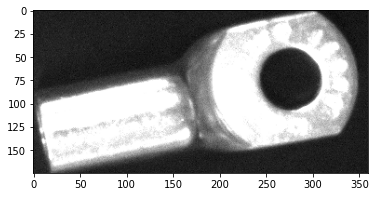

In [ ]:
iiii = np.array(kimage.load_img(template_path))
plt.imshow(iiii[65:240, 30:390]/255.0)
print(iiii[65:240, 30:390].shape)

In [ ]:
def rotateAndScale(img, scaleFactor = 0.5, degreesCCW = 30):
    (oldY,oldX) = img.shape[:2] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=degreesCCW, scale=scaleFactor) #rotate about center of image.

    #choose a new image size.
    newX,newY = oldX*scaleFactor,oldY*scaleFactor
    #include this if you want to prevent corners being cut off
    r = np.deg2rad(degreesCCW)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    #the warpAffine function call, below, basically works like this:
    # 1. apply the M transformation on each pixel of the original image
    # 2. save everything that falls within the upper-left "dsize" portion of the resulting image.

    #So I will find the translation that moves the result to the center of that region.
    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty

    rotatedImg = cv2.warpAffine(img, M, dsize=(int(newX),int(newY)))
    return rotatedImg
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


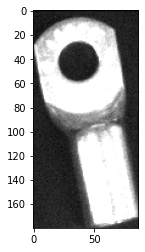

In [ ]:
a = rotateAndScale(iiii[65:240, 30:390], scaleFactor = 0.5, degreesCCW = 90)
plt.imshow(a/225.0)

In [ ]:
HEIGHT = 360
DELTA = 100
scale_levels = 6
list_of_templates = []
image1 = kimage.load_img(image1_path)
image1 = np.expand_dims(image1, axis=0)
image2 = kimage.load_img(image2_path)
image2 = np.expand_dims(image2, axis=0)

STEP_DEGREE = 15
# rotate_list = np.arange(0,2*np.pi, 2*np.pi*STEP_DEGREE/360)
rotate_list = np.arange(0,360, 15)
dict_size_template = {}
count = 0
tempt = np.array(kimage.load_img(template_path,))
tempt = tempt[65:240, 30:390]
for sc_lv in range(scale_levels):
  scale_h = HEIGHT+DELTA*(sc_lv-((scale_levels-1)//2))
  scale_w = scale_h*2
  for r_deg in rotate_list:
    dict_size_template[count] = (scale_h, scale_w)
    # tempt_resize = tf.image.resize(tempt, size=(scale_h, scale_w))
    tempt_resize = cv2.resize(tempt, (scale_w,scale_h))
    tempt_rot = rotateAndScale(tempt_resize, scaleFactor = 0.5, degreesCCW = r_deg)
    tempt_array = np.expand_dims(tempt_rot, axis=0)
    # tempt_rot = tfa.image.rotate(tf.cast(tempt_array, dtype=tf.float32), tf.constant(r_deg, dtype=tf.float32))
    list_of_templates.append(tempt_array)
    count += 1





In [ ]:
print(image1.shape)
print(image2.shape)

for i in range(5):
  print(list_of_templates[i].shape)

(1, 1200, 1600, 3)
(1, 1200, 1600, 3)
(1, 80, 160, 3)
(1, 118, 175, 3)
(1, 149, 178, 3)
(1, 169, 169, 3)
(1, 178, 149, 3)
(1, 175, 118, 3)


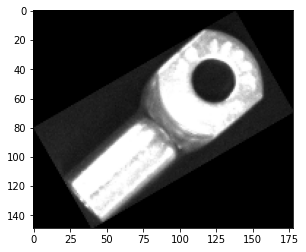

In [ ]:
plt.imshow(list_of_templates[2][0]/255.0)

In [ ]:
def compute_feature(img_list):
  model = keras.applications.VGG16(include_top=False, weights='imagenet')
  list_features = []
  for img in img_list:
    prep_im = keras.applications.vgg16.preprocess_input(img)
    feature = model(prep_im)
    list_features.append(feature)
  return list_features


In [ ]:
image1_fm = compute_feature([image1])[0]
image2_fm = compute_feature([image2])[0]
list_templates_fm =  compute_feature(list_of_templates)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
print(image1_fm.shape)
print(image2_fm.shape)
for i in range(5):
  print(list_templates_fm[i].shape)

(1, 37, 50, 512)
(1, 37, 50, 512)
(1, 2, 5, 512)
(1, 3, 5, 512)
(1, 4, 5, 512)
(1, 5, 5, 512)
(1, 5, 4, 512)
(1, 5, 3, 512)


In [ ]:
def matching_image(image, template_list):
  image = np.squeeze(image)
  im_h, im_w = image.shape[:2]
  distance_list = []
  for idx_template, template in tqdm(enumerate(template_list)):
    template = np.squeeze(template)
    tmp_h, tmp_w = template.shape[:2]
    template = np.reshape(template, (1, -1))
    for row in range(im_h- tmp_h + 1):
      for col in range(im_w- tmp_w + 1):
        covered_region = image[row:row+tmp_h, col:col+tmp_w, :]
        covered_region = np.reshape(covered_region, (1, -1))
        distance = cosine_similarity(template, covered_region)
        distance_list.append([distance, row, col, idx_template])
  return distance_list

In [ ]:
distance_list1 = matching_image(image1_fm, list_templates_fm)
distance_list2 = matching_image(image2_fm, list_templates_fm)

144it [01:29,  1.61it/s]
144it [01:27,  1.64it/s]


In [ ]:
np.save('distance_list1.npy', distance_list1)
np.save('distance_list2.npy', distance_list2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
def retkey(x):
  return x[0]
sorted_distance_list1 = sorted(distance_list1, key=retkey, reverse=True)
sorted_distance_list2 = sorted(distance_list2, key=retkey, reverse=True)

<Figure size 1152x1152 with 0 Axes>

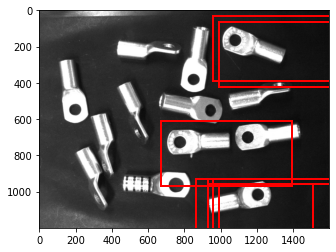

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
im = kimage.load_img(image1_path)
plt.figure(figsize=(16,16))
fig, ax = plt.subplots()
ax.imshow(im)


width, height = im.size
# Create a Rectangle patch

for i in range(10): 
  tmp_res = sorted_distance_list1[i]
  height_fm, width_fm = dict_size_template[tmp_res[-1]]
  scale_height = height//37#height_fm
  scale_width  = width//50#width_fm
  rect = patches.Rectangle((tmp_res[2]*scale_width, tmp_res[1]*scale_height), 
                          width_fm, height_fm, 
                          linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
plt.show()

<Figure size 1152x1152 with 0 Axes>

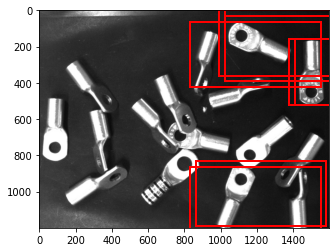

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
im = kimage.load_img(image2_path)
plt.figure(figsize=(16,16))
fig, ax = plt.subplots()
ax.imshow(im)


width, height = im.size
# Create a Rectangle patch

for i in range(10): 
  tmp_res = sorted_distance_list2[i]
  height_fm, width_fm = dict_size_template[tmp_res[-1]]
  scale_height = height//37#height_fm
  scale_width  = width//50#width_fm
  rect = patches.Rectangle((tmp_res[2]*scale_width, tmp_res[1]*scale_height), 
                          width_fm, height_fm, 
                          linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
plt.show()

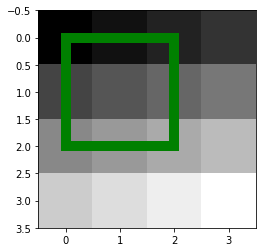

In [ ]:

import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle 
  
  
# The image 
X = np.arange(16).reshape(4, 4) 
  
# highlight some feature in the 
# middle boxes. 
fig = plt.figure() 
  
ax = fig.add_subplot(111) 
ax.imshow(X, cmap = plt.cm.gray, 
          interpolation ='nearest') 
ax.add_patch( Rectangle((0.0, 0.0), 
                        2, 2, 
                        fc ='none',  
                        ec ='g', 
                        lw = 10) ) 
  
plt.show() 

In [ ]:
37*32

1184

In [ ]:
50*32

1600

In [ ]:
19, 32